In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-16 22:40:40.122058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 22:40:40.302227: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-16 22:40:40.936005: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Description of the following cell

> Here, we load the dataset, select the last snapshot and construct the required inputs/outputs array. After that, we turn them into a tensorflow dataset.
> The Right-Hand-Side derivatives of the actual values plotted at the end.

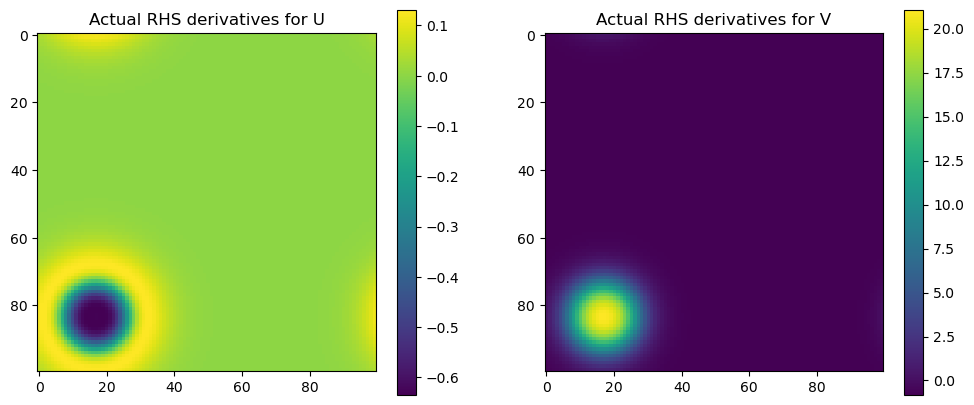

In [3]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-3,
               data_time_len=2,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)
ts = tf.constant(pattern.t_star[-1:], dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H = tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
# Data is a three column matrix as (x,y,t), where
# first x changes, then y, and finally t (like Boolean tables)
data = tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))
#Select the last time step
# and reorder the x and y to match it
# with H
c_copy = np.einsum("cxy -> cyx", pattern.c[..., -1].copy())
#reshape c to flatten the data for each species
c = c_copy.reshape((2, pattern.c.shape[1]*pattern.c.shape[2]))
# and finnaly use its transposed, to have the each speacices in on column 
c = c.T
def gen_series():    
    
    for i in range(data.shape[0]):
        h = data[i,:]
        yield h, c[i,:]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((3,),(2,)))
############
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Actual RHS derivatives for U")
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.title("Actual RHS derivatives for V")
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar();plt.show()

# Scaled NN
> To check that including the scale has effect on the learning of the derivatives, I create a second class here that its activations have an extra term like $\sigma(a w x + b)$.

In [4]:
class NN_scaled(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
        
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, a ,b in zip(self.weights, self.scales, self.biases):
            outputs = tf.matmul(H, W)
            outputs = a*outputs + b
            H = tf.tanh(outputs)
        return outputs

# Helper methods

> The grads method finds gradients of a provided PINN and a given input
> The second function create a train_step function for  a PINN, an optimiser, and the parameters

In [5]:
# Calculate the gradient of a given input
def grads(pinn, inputs, squeeze=False):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        grad_u_y = tape.gradient(u_y, inputs)
        u_yy = grad_u_y[:, 1]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        grad_v_y = tape.gradient(v_y, inputs)
        v_yy = grad_v_y[:, 1]
    if squeeze:
        return (tf.squeeze(u),
                tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
                tf.squeeze(v),
                tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))
    else:
        return (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t)

# The following helper method creates a training step
# function for a PINN, an optimiser, and the parameters
def create_train_step(pinn, optimizer, D_u, D_v, 
                      sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,
                      include_u_t = True):
    @tf.function
    def train_step(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                ug = tf.squeeze(outputs[:, 0])
                vg = tf.squeeze(outputs[:, 1])

                grad_u = tape2.gradient(ug, H)
                u_x = grad_u[:, 0]
                u_y = grad_u[:, 1]
                if include_u_t:
                    u_t = grad_u[:, 2]

                grad_v = tape2.gradient(vg, H)
                v_x = grad_v[:, 0]
                v_y = grad_v[:, 1]
                if include_u_t:
                    v_t = grad_v[:, 2]

            grad_u_x = tape.gradient(u_x, H)
            u_xx = grad_u_x[:, 0]
            grad_u_y = tape.gradient(u_y, H)
            u_yy = grad_u_y[:, 1]
            grad_v_x = tape.gradient(v_x, H)
            v_xx = grad_v_x[:, 0]
            grad_v_y = tape.gradient(v_y, H)
            v_yy = grad_v_y[:, 1]

            u = tf.squeeze(elements[1][:, 0])
            v = tf.squeeze(elements[1][:, 1])
            f = u * u * v / (1.0 + kappa_u * u * u)
            
            f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u
            f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v
            if include_u_t:
                f_u = f_u - u_t
                f_v = f_v - v_t
            l2_res_u = tf.reduce_sum(f_u**2)
            l2_res_v = tf.reduce_sum(f_v**2)

            l2 = l2_res_u + l2_res_v

        grads = tape.gradient(l2, trainables)

        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_u, l2_res_v)
    return train_step

# Test 1:
### A usual PINN without the scale, including time derivatives

> By fixing the actual parameter and using the actual u and v, we train the RHS
$ D_u(\partial_{xx} + \partial_{yy})u -\partial_t u$ and $ D_v(\partial_{xx} + \partial_{yy})v -\partial_t v$.

In [6]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn1 = tu.NN([3, 128, 128, 2], lb, ub, tf.float32)



def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

def create_tf_var(name,dtype, init_perturbation = 1.0):
    return tf.Variable(pattern.params[name]*init_perturbation,
                       dtype,
                       name=name,
                       constraint=clip_by_value_zero_lb)

init_per = 1.0
D_u = create_tf_var("D_u", pinn1.dtype, init_per)
D_v = create_tf_var("D_v", pinn1.dtype, init_per)
sigma_u = create_tf_var("sigma_u", pinn1.dtype, init_per)
sigma_v = create_tf_var("sigma_v", pinn1.dtype, init_per)
mu_u = create_tf_var("mu_u", pinn1.dtype, init_per)
rho_u = create_tf_var("rho_u", pinn1.dtype, init_per)
rho_v = create_tf_var("rho_v", pinn1.dtype, init_per)
kappa_u = create_tf_var("kappa_u", pinn1.dtype, init_per)


In [7]:
batch_size = 5000

optimizer=keras.optimizers.Adam(learning_rate=1e-2)
train_step_1 = create_train_step(pinn1, optimizer, 
                                D_u, D_v,
                                sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,
                                include_u_t = True)

def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           )
    
losses = tu.train(epochs=20000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_1,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0


2023-02-16 22:41:18.023304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-16 22:41:18.049566: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f579c0035a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-16 22:41:18.049608: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-02-16 22:41:18.057655: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-16 22:41:18.498747: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0
 total loss: 146372.2402191162  u: 1310.474594116211,  v: 145061.765625,

Time taken: 13.69s

Start of epoch 100
at epoch 100
 total loss: 443.5457191467285  u: 34.52431106567383,  v: 409.0214080810547,

Time taken: 5.28s

Start of epoch 200
at epoch 200
 total loss: 335.8665523529053  u: 15.615079879760742,  v: 320.25147247314453,

Time taken: 5.28s

Start of epoch 300
at epoch 300
 total loss: 203.7183060646057  u: 11.5169358253479,  v: 192.2013702392578,

Time taken: 5.15s

Start of epoch 400
at epoch 400
 total loss: 119.00464606285095  u: 9.444202184677124,  v: 109.56044387817383,

Time taken: 5.17s

Start of epoch 500
at epoch 500
 total loss: 114.59930181503296  u: 8.249204158782959,  v: 106.35009765625,

Time taken: 5.28s

Start of epoch 600
at epoch 600
 total loss: 186.37035036087036  u: 6.4770188331604,  v: 179.89333152770996,

Time taken: 5.32s

Start of epoch 700
at epoch 700
 total loss: 165.43546962738037  u: 5.86942195892334,  v: 159.56604766845703,

Time tak


Start of epoch 6300
at epoch 6300
 total loss: 528.4140787124634  u: 12.993939399719238,  v: 515.4201393127441,

Time taken: 5.10s

Start of epoch 6400
at epoch 6400
 total loss: 72.94834578037262  u: 9.282444596290588,  v: 63.66590118408203,

Time taken: 5.24s

Start of epoch 6500
at epoch 6500
 total loss: 103.36918380856514  u: 5.294617921113968,  v: 98.07456588745117,

Time taken: 5.33s

Start of epoch 6600
at epoch 6600
 total loss: 237.61964410543442  u: 17.47771829366684,  v: 220.14192581176758,

Time taken: 5.21s

Start of epoch 6700
at epoch 6700
 total loss: 145.62090104818344  u: 5.257236421108246,  v: 140.3636646270752,

Time taken: 5.15s

Start of epoch 6800
at epoch 6800
 total loss: 73.28894376754761  u: 5.419478893280029,  v: 67.86946487426758,

Time taken: 5.20s

Start of epoch 6900
at epoch 6900
 total loss: 256.2397447824478  u: 8.457129120826721,  v: 247.7826156616211,

Time taken: 5.11s

Start of epoch 7000
at epoch 7000
 total loss: 142.46004498004913  u: 5.08762


Start of epoch 12500
at epoch 12500
 total loss: 91.301363453269  u: 8.82067559659481,  v: 82.4806878566742,

Time taken: 5.20s

Start of epoch 12600
at epoch 12600
 total loss: 40.166586458683014  u: 6.928058683872223,  v: 33.23852777481079,

Time taken: 5.17s

Start of epoch 12700
at epoch 12700
 total loss: 42.79776781797409  u: 6.606255948543549,  v: 36.19151186943054,

Time taken: 5.13s

Start of epoch 12800
at epoch 12800
 total loss: 213.15773050487041  u: 8.55216209590435,  v: 204.60556840896606,

Time taken: 5.06s

Start of epoch 12900
at epoch 12900
 total loss: 241.4205183684826  u: 10.708934277296066,  v: 230.71158409118652,

Time taken: 5.13s

Start of epoch 13000
at epoch 13000
 total loss: 74.52585585415363  u: 6.240771368145943,  v: 68.28508448600769,

Time taken: 5.22s

Start of epoch 13100
at epoch 13100
 total loss: 46.52530813217163  u: 6.776217937469482,  v: 39.74909019470215,

Time taken: 5.17s

Start of epoch 13200
at epoch 13200
 total loss: 37.540810227394104 


Start of epoch 18700
at epoch 18700
 total loss: 541.469464302063  u: 10.613999366760254,  v: 530.8554649353027,

Time taken: 5.10s

Start of epoch 18800
at epoch 18800
 total loss: 140.15566205978394  u: 8.689952373504639,  v: 131.4657096862793,

Time taken: 5.15s

Start of epoch 18900
at epoch 18900
 total loss: 123.34151476621628  u: 7.617181956768036,  v: 115.72433280944824,

Time taken: 5.25s

Start of epoch 19000
at epoch 19000
 total loss: 143.534881234169  u: 9.144027352333069,  v: 134.39085388183594,

Time taken: 5.15s

Start of epoch 19100
at epoch 19100
 total loss: 372.4202923178673  u: 8.696031987667084,  v: 363.7242603302002,

Time taken: 5.19s

Start of epoch 19200
at epoch 19200
 total loss: 232.3004378080368  u: 8.61047351360321,  v: 223.6899642944336,

Time taken: 5.21s

Start of epoch 19300
at epoch 19300
 total loss: 131.79786705970764  u: 7.89569878578186,  v: 123.90216827392578,

Time taken: 5.20s

Start of epoch 19400
at epoch 19400
 total loss: 152.589569151401

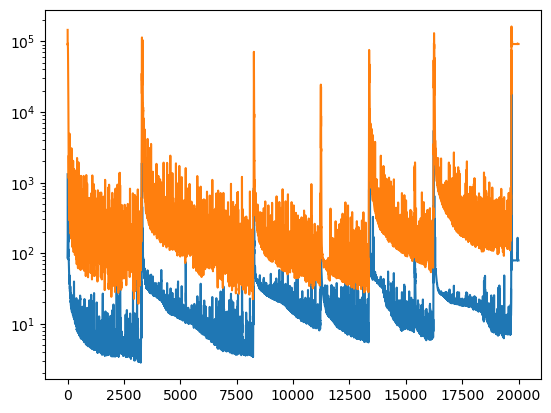

In [8]:
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.yscale('log')

In [9]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn1, data)

In [10]:
def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy)) - to(u_t)
v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy)) - to(v_t)
# X and Y are miss-oriented
u_der = u_der.T
v_der = v_der.T

u = pattern.c[0,:, : , -1]
v = pattern.c[1,:, : , -1]
f = u * u * v / (1.0 + kappa_u * u * u)
f_u =  rho_u * f - mu_u * u + sigma_u
f_v =  - rho_v * f + sigma_v

# Test 1 results:

#### Below, we can see the results of trained derivatives and the RHS.

## Verdict: It capture the patterns and amplitude.

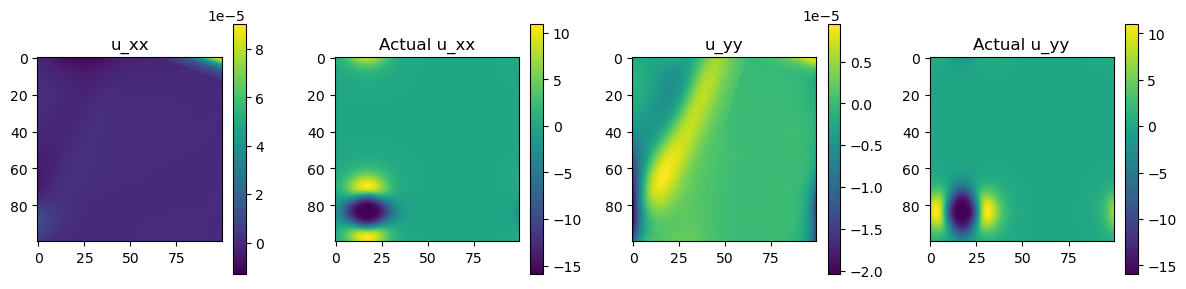

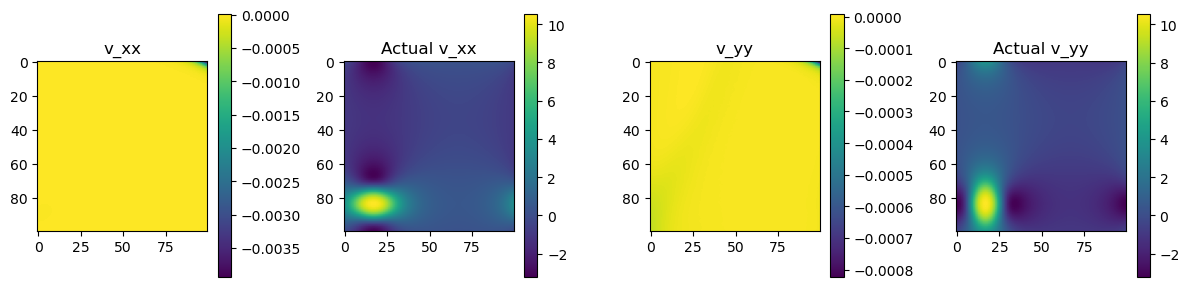

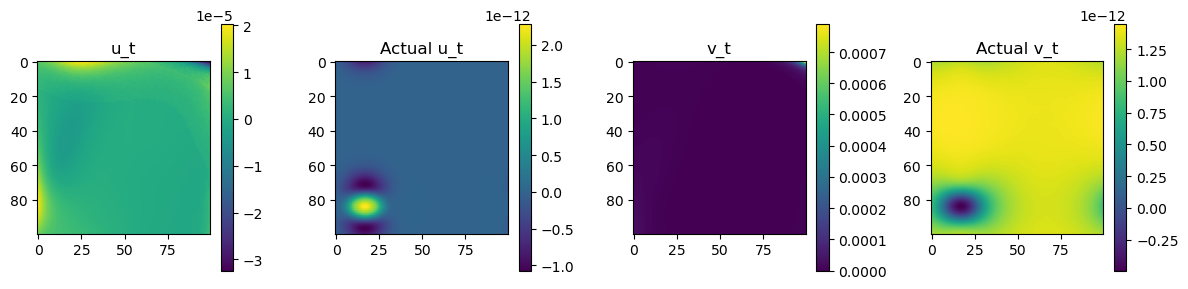

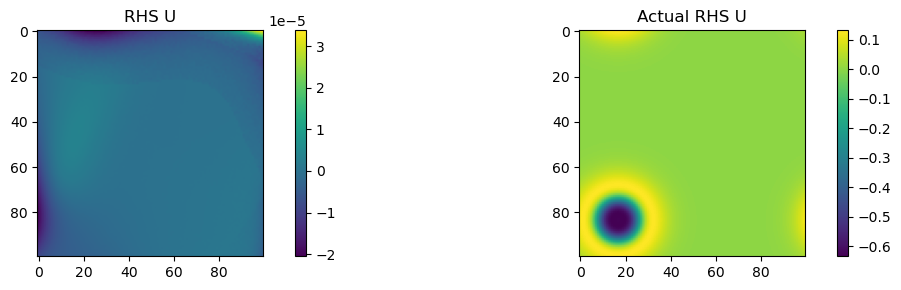

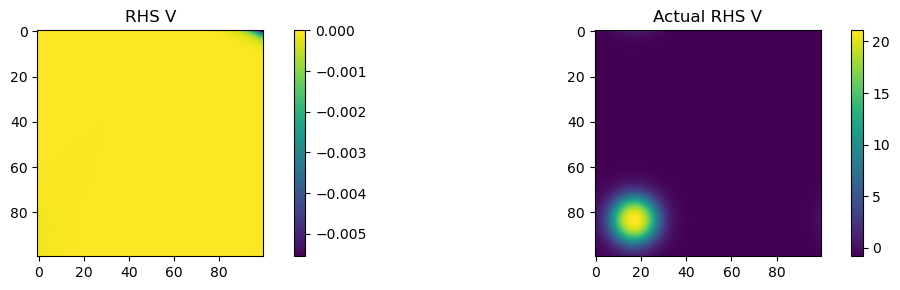

In [13]:
plot_n_im([to(u_xx).T, pattern.c_xx[0,:, : , -1], to(u_yy).T, pattern.c_yy[0,:, : , -1]], 
          ["u_xx", "Actual u_xx", "u_yy", "Actual u_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(v_xx).T, pattern.c_xx[1,:, : , -1], to(v_yy).T, pattern.c_yy[1,:, : , -1]],
          ["v_xx", "Actual v_xx", "v_yy", "Actual v_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(u_t).T,  pattern.c_t[0,:, : , -1],  to(v_t).T,  pattern.c_t[1,:, : , -1]],
          ["u_t", "Actual u_t", "v_t", "Actual v_t"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([u_der,  actual_u_der],
          ["RHS U", "Actual RHS U"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([v_der,  actual_v_der],
          ["RHS V", "Actual RHS V"],          
          figsize=(12, 3)); plt.tight_layout()

# Test 2:

### An scaled PINN, including time derivatives

> By fixing the actual parameter and using the actual u and v, we train the RHS
$ D_u(\partial_{xx} + \partial_{yy})u -\partial_t u$ and $ D_v(\partial_{xx} + \partial_{yy})v -\partial_t v$.

In [14]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn2 = NN_scaled([3, 128, 128, 2], lb, ub, tf.float32)



def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

def create_tf_var(name,dtype, init_perturbation = 1.0):
    return tf.Variable(pattern.params[name]*init_perturbation,
                       dtype,
                       name=name,
                       constraint=clip_by_value_zero_lb)

init_per = 1.0
D_u = create_tf_var("D_u", pinn2.dtype, init_per)
D_v = create_tf_var("D_v", pinn2.dtype, init_per)
sigma_u = create_tf_var("sigma_u", pinn2.dtype, init_per)
sigma_v = create_tf_var("sigma_v", pinn2.dtype, init_per)
mu_u = create_tf_var("mu_u", pinn2.dtype, init_per)
rho_u = create_tf_var("rho_u", pinn2.dtype, init_per)
rho_v = create_tf_var("rho_v", pinn2.dtype, init_per)
kappa_u = create_tf_var("kappa_u", pinn2.dtype, init_per)


In [15]:
batch_size = 5000

optimizer2=keras.optimizers.Adam(learning_rate=1e-2)
train_step_2 = create_train_step(pinn2, optimizer2, 
                                 D_u, D_v,
                                 sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,
                                 include_u_t = True)

def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           )
    
losses2 = tu.train(epochs=20000+1,
                   batch_size=batch_size,
                   dataset = ds ,
                   train_step = train_step_2,
                   train_step_returns_num = 2,
                   print_interval=100,
                   loss_sample_interval = 1,
                   stop_threshold=1e-5,
                   print_callback = print_callback,
                   epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 169238.91681671143  u: 2777.651191711426,  v: 166461.265625,

Time taken: 15.47s

Start of epoch 100
at epoch 100
 total loss: 461.7373847961426  u: 30.132526397705078,  v: 431.6048583984375,

Time taken: 5.53s

Start of epoch 200
at epoch 200
 total loss: 174.7859501838684  u: 14.65327501296997,  v: 160.13267517089844,

Time taken: 5.63s

Start of epoch 300
at epoch 300
 total loss: 1786.811512351036  u: 15.694645285606384,  v: 1771.1168670654297,

Time taken: 5.68s

Start of epoch 400
at epoch 400
 total loss: 108.31779932975769  u: 9.530836820602417,  v: 98.78696250915527,

Time taken: 5.64s

Start of epoch 500
at epoch 500
 total loss: 1139.4760246276855  u: 14.913288116455078,  v: 1124.5627365112305,

Time taken: 5.62s

Start of epoch 600
at epoch 600
 total loss: 570.6310983896255  u: 8.911352753639221,  v: 561.7197456359863,

Time taken: 5.57s

Start of epoch 700
at epoch 700
 total loss: 54.44301390647888  u: 6.065313100814819,  v: 48.3


Start of epoch 6300
at epoch 6300
 total loss: 64.96608600020409  u: 2.457460731267929,  v: 62.50862526893616,

Time taken: 5.52s

Start of epoch 6400
at epoch 6400
 total loss: 49.80918526649475  u: 1.966599702835083,  v: 47.84258556365967,

Time taken: 5.54s

Start of epoch 6500
at epoch 6500
 total loss: 167.53802171349525  u: 2.72008815407753,  v: 164.81793355941772,

Time taken: 5.57s

Start of epoch 6600
at epoch 6600
 total loss: 6.279526710510254  u: 1.7644532918930054,  v: 4.5150734186172485,

Time taken: 5.53s

Start of epoch 6700
at epoch 6700
 total loss: 50.91959124803543  u: 1.9484637379646301,  v: 48.9711275100708,

Time taken: 5.65s

Start of epoch 6800
at epoch 6800
 total loss: 34.504305109381676  u: 2.082773193717003,  v: 32.42153191566467,

Time taken: 5.60s

Start of epoch 6900
at epoch 6900
 total loss: 22.851198434829712  u: 1.7456390857696533,  v: 21.10555934906006,

Time taken: 5.63s

Start of epoch 7000
at epoch 7000
 total loss: 143.22104635834694  u: 2.8791


Start of epoch 12500
at epoch 12500
 total loss: 35.69985297136009  u: 1.204176364466548,  v: 34.49567660689354,

Time taken: 5.50s

Start of epoch 12600
at epoch 12600
 total loss: 355.7805972844362  u: 1.543459728360176,  v: 354.23713755607605,

Time taken: 5.63s

Start of epoch 12700
at epoch 12700
 total loss: 41.6945835351944  u: 1.15406334400177,  v: 40.54052019119263,

Time taken: 5.54s

Start of epoch 12800
at epoch 12800
 total loss: 5.933382594957948  u: 1.2268637362867594,  v: 4.706518858671188,

Time taken: 5.59s

Start of epoch 12900
at epoch 12900
 total loss: 83.4221260547638  u: 1.2257719039916992,  v: 82.1963541507721,

Time taken: 5.76s

Start of epoch 13000
at epoch 13000
 total loss: 2.3085433207452297  u: 1.1031433157622814,  v: 1.2054000049829483,

Time taken: 5.71s

Start of epoch 13100
at epoch 13100
 total loss: 17.055687330663204  u: 1.0784222707152367,  v: 15.977265059947968,

Time taken: 5.65s

Start of epoch 13200
at epoch 13200
 total loss: 6.329394817352


Start of epoch 18600
at epoch 18600
 total loss: 19.360714629292488  u: 0.6317288428544998,  v: 18.72898578643799,

Time taken: 4.74s

Start of epoch 18700
at epoch 18700
 total loss: 4.0945496037602425  u: 0.5949381664395332,  v: 3.4996114373207092,

Time taken: 5.25s

Start of epoch 18800
at epoch 18800
 total loss: 7.662270728498697  u: 0.4696281887590885,  v: 7.192642539739609,

Time taken: 5.05s

Start of epoch 18900
at epoch 18900
 total loss: 25.713021958246827  u: 0.5148560646921396,  v: 25.198165893554688,

Time taken: 5.07s

Start of epoch 19000
at epoch 19000
 total loss: 70.2156672924757  u: 0.9975593537092209,  v: 69.21810793876648,

Time taken: 5.05s

Start of epoch 19100
at epoch 19100
 total loss: 12.763846285641193  u: 0.6854647472500801,  v: 12.078381538391113,

Time taken: 5.24s

Start of epoch 19200
at epoch 19200
 total loss: 29.608207270503044  u: 0.5951214283704758,  v: 29.01308584213257,

Time taken: 5.35s

Start of epoch 19300
at epoch 19300
 total loss: 87.10

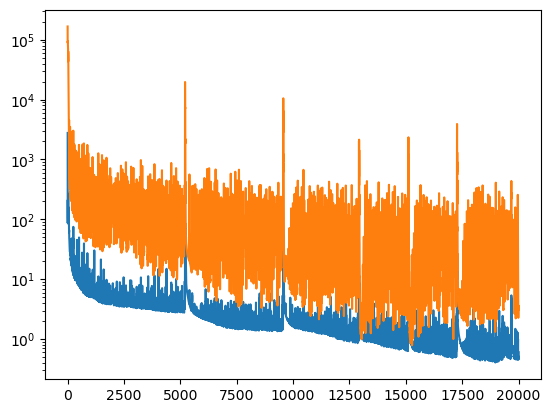

In [16]:
plt.plot(losses2[:,0])
plt.plot(losses2[:,1])
plt.yscale('log')

In [17]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn2, data)

In [18]:
def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy)) - to(u_t)
v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy)) - to(v_t)
# X and Y are miss-oriented
u_der = u_der.T
v_der = v_der.T

u = pattern.c[0,:, : , -1]
v = pattern.c[1,:, : , -1]
f = u * u * v / (1.0 + kappa_u * u * u)
f_u =  rho_u * f - mu_u * u + sigma_u
f_v =  - rho_v * f + sigma_v

# Test 2 results:

#### Below, we can see the results of trained derivatives and the RHS.

## Verdict: It capture the patterns and amplitude.

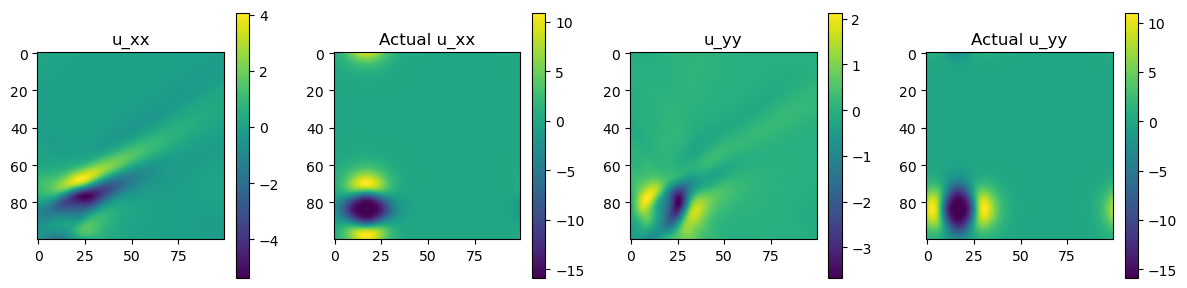

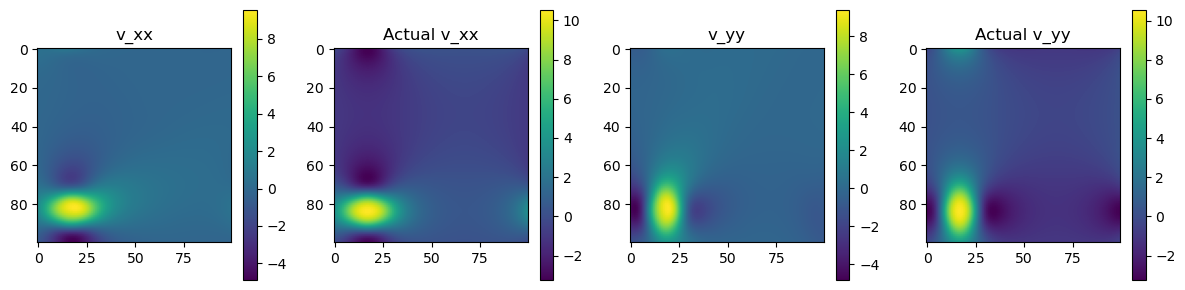

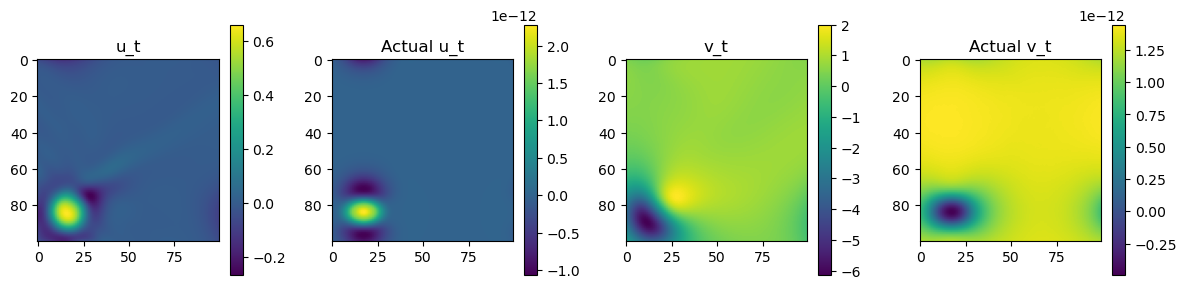

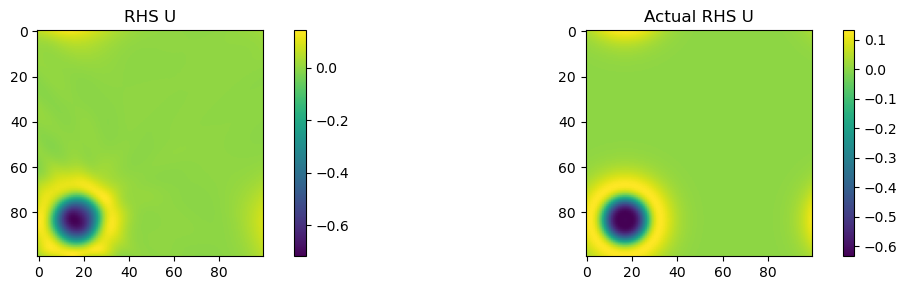

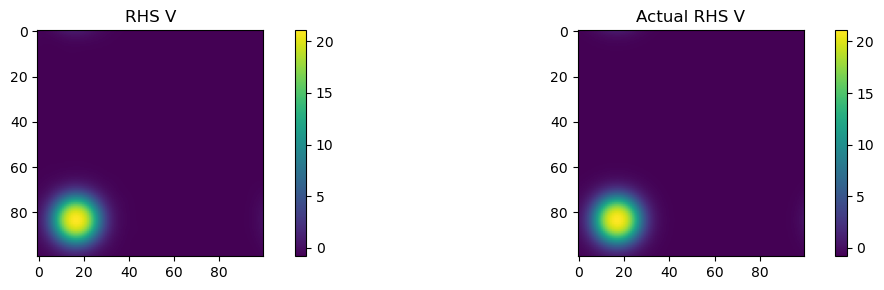

In [19]:
plot_n_im([to(u_xx).T, pattern.c_xx[0,:, : , -1], to(u_yy).T, pattern.c_yy[0,:, : , -1]], 
          ["u_xx", "Actual u_xx", "u_yy", "Actual u_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(v_xx).T, pattern.c_xx[1,:, : , -1], to(v_yy).T, pattern.c_yy[1,:, : , -1]],
          ["v_xx", "Actual v_xx", "v_yy", "Actual v_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(u_t).T,  pattern.c_t[0,:, : , -1],  to(v_t).T,  pattern.c_t[1,:, : , -1]],
          ["u_t", "Actual u_t", "v_t", "Actual v_t"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([u_der,  actual_u_der],
          ["RHS U", "Actual RHS U"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([v_der,  actual_v_der],
          ["RHS V", "Actual RHS V"],          
          figsize=(12, 3)); plt.tight_layout()

In [33]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn3 = tu.NN([3, 128, 128, 2], lb, ub, tf.float32)



def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

def create_tf_var(name,dtype, init_perturbation = 1.0):
    return tf.Variable(pattern.params[name]*init_perturbation,
                       dtype,
                       name=name,
                       constraint=clip_by_value_zero_lb)

init_per = 1.0
D_u = create_tf_var("D_u", pinn1.dtype, init_per)
D_v = create_tf_var("D_v", pinn1.dtype, init_per)
sigma_u = create_tf_var("sigma_u", pinn1.dtype, init_per)
sigma_v = create_tf_var("sigma_v", pinn1.dtype, init_per)
mu_u = create_tf_var("mu_u", pinn1.dtype, init_per)
rho_u = create_tf_var("rho_u", pinn1.dtype, init_per)
rho_v = create_tf_var("rho_v", pinn1.dtype, init_per)
kappa_u = create_tf_var("kappa_u", pinn1.dtype, init_per)

In [34]:
batch_size = 5000

optimizer3=keras.optimizers.Adam(learning_rate=1e-2)
train_step_3 = create_train_step(pinn3, optimizer3, 
                                D_u, D_v,
                                sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,
                                include_u_t = True)

def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           )
    
losses3 = tu.train(epochs=7000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_3,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 162675.39111328125  u: 4241.85205078125,  v: 158433.5390625,

Time taken: 18.98s

Start of epoch 100
at epoch 100
 total loss: 819.9021029472351  u: 35.816211223602295,  v: 784.0858917236328,

Time taken: 5.23s

Start of epoch 200
at epoch 200
 total loss: 2189.840103149414  u: 29.3199462890625,  v: 2160.5201568603516,

Time taken: 5.29s

Start of epoch 300
at epoch 300
 total loss: 308.6370825767517  u: 21.326634883880615,  v: 287.3104476928711,

Time taken: 5.32s

Start of epoch 400
at epoch 400
 total loss: 1089.2372392416  u: 17.142348647117615,  v: 1072.0948905944824,

Time taken: 5.24s

Start of epoch 500
at epoch 500
 total loss: 212.3732739686966  u: 12.223676800727844,  v: 200.14959716796875,

Time taken: 5.25s

Start of epoch 600
at epoch 600
 total loss: 272.03935515880585  u: 11.27850615978241,  v: 260.76084899902344,

Time taken: 5.30s

Start of epoch 700
at epoch 700
 total loss: 616.2051115036011  u: 10.946394920349121,  v: 605.2


Start of epoch 6300
at epoch 6300
 total loss: 22.86246667802334  u: 1.733113631606102,  v: 21.129353046417236,

Time taken: 5.23s

Start of epoch 6400
at epoch 6400
 total loss: 165.41793781518936  u: 3.2463794350624084,  v: 162.17155838012695,

Time taken: 5.30s

Start of epoch 6500
at epoch 6500
 total loss: 73.04022312164307  u: 9.1891450881958,  v: 63.851078033447266,

Time taken: 5.24s

Start of epoch 6600
at epoch 6600
 total loss: 125.27055621147156  u: 7.7290427684783936,  v: 117.54151344299316,

Time taken: 5.22s

Start of epoch 6700
at epoch 6700
 total loss: 120.60510683059692  u: 9.934544563293457,  v: 110.67056226730347,

Time taken: 5.20s

Start of epoch 6800
at epoch 6800
 total loss: 360.0251829624176  u: 17.720776796340942,  v: 342.30440616607666,

Time taken: 5.24s

Start of epoch 6900
at epoch 6900
 total loss: 64.17978358268738  u: 5.493938207626343,  v: 58.685845375061035,

Time taken: 5.24s

Start of epoch 7000
at epoch 7000
 total loss: 132.47338408231735  u: 2

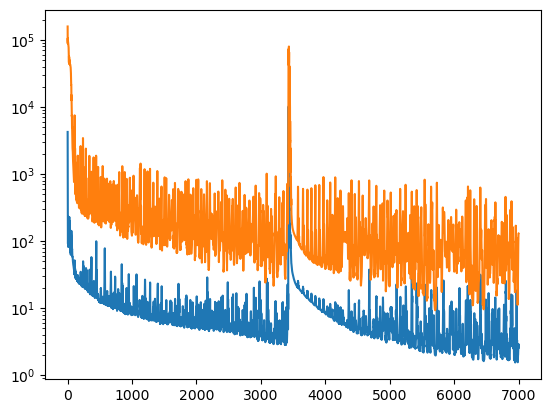

In [35]:
plt.plot(losses3[:,0])
plt.plot(losses3[:,1])
plt.yscale('log')

In [36]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn3, data)

In [37]:
def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy)) - to(u_t)
v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy)) - to(v_t)
# X and Y are miss-oriented
u_der = u_der.T
v_der = v_der.T

u = pattern.c[0,:, : , -1]
v = pattern.c[1,:, : , -1]
f = u * u * v / (1.0 + kappa_u * u * u)
f_u =  rho_u * f - mu_u * u + sigma_u
f_v =  - rho_v * f + sigma_v

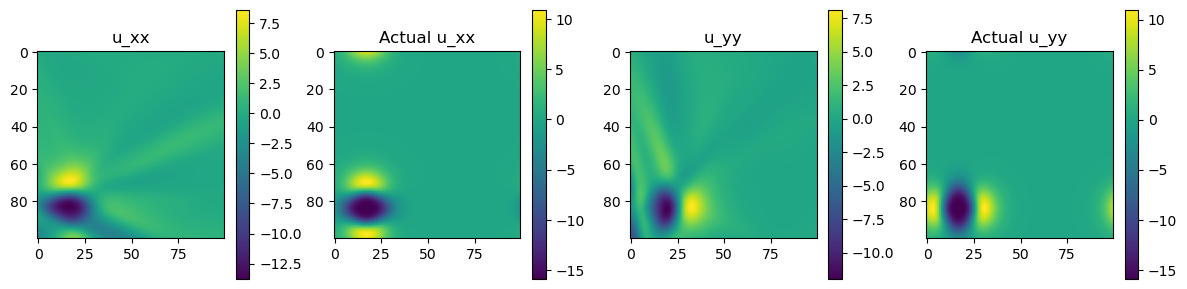

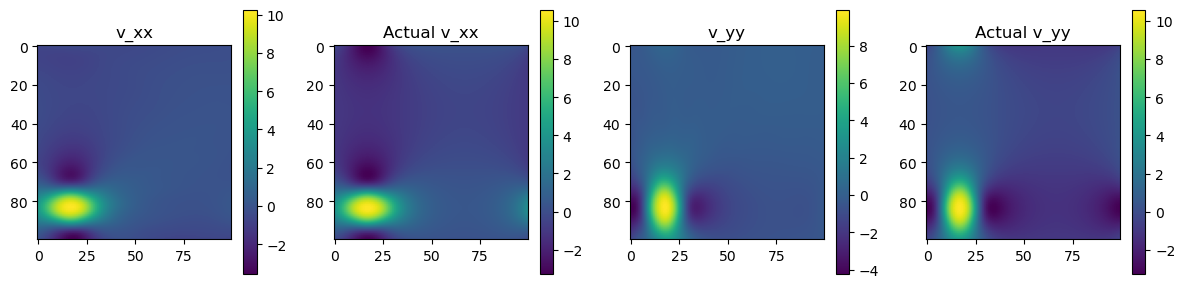

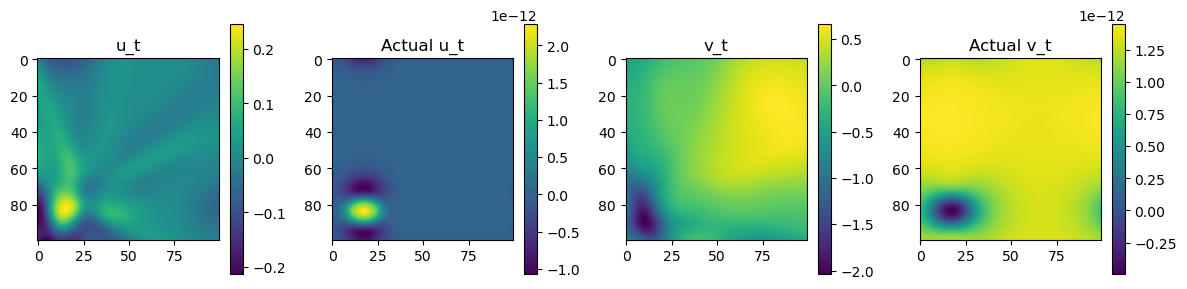

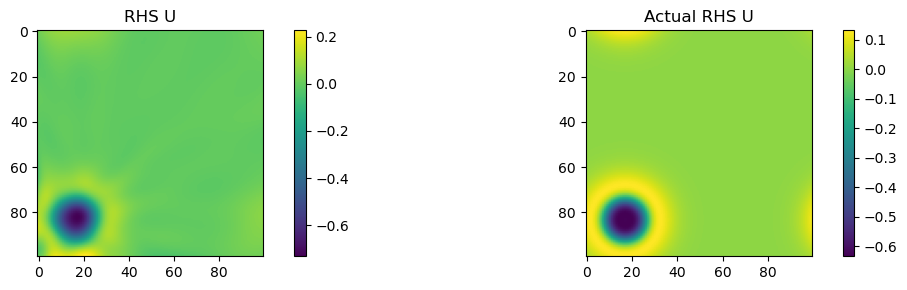

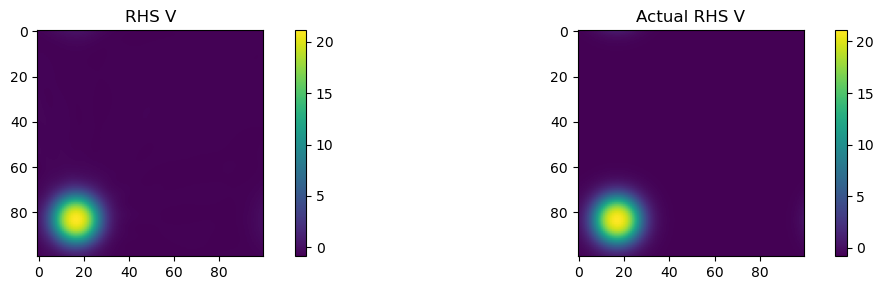

In [38]:
plot_n_im([to(u_xx).T, pattern.c_xx[0,:, : , -1], to(u_yy).T, pattern.c_yy[0,:, : , -1]], 
          ["u_xx", "Actual u_xx", "u_yy", "Actual u_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(v_xx).T, pattern.c_xx[1,:, : , -1], to(v_yy).T, pattern.c_yy[1,:, : , -1]],
          ["v_xx", "Actual v_xx", "v_yy", "Actual v_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(u_t).T,  pattern.c_t[0,:, : , -1],  to(v_t).T,  pattern.c_t[1,:, : , -1]],
          ["u_t", "Actual u_t", "v_t", "Actual v_t"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([u_der,  actual_u_der],
          ["RHS U", "Actual RHS U"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([v_der,  actual_v_der],
          ["RHS V", "Actual RHS V"],          
          figsize=(12, 3)); plt.tight_layout()